In [1]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt

# Constant
# [Hue maximum possible value, Saturation maximum possible value, Value maximum possible value]
MAX_COLOR = [179, 255, 255]

# Input image name
INPUT_IMAGE_NAME = 'test.tiff'

# Input parameters initialization
COLOR_TO_LOOK_FOR = [117, 255, 254]  # HSV color
PICKER_COLOR = [0, 0, 0]  # HSV color picker current color
TOLERANCE = [10, 100, 100] # [Hue tolerance, Saturation tolerance, Value tolerance]
MIN_AREA = 0
MARKER_COLOR = [255, 255, 255]
MARKER_THICKNESS = 1


def getBoundaries(color, tolerance):
    minBoundary = np.array(
        [max(0, color[i] - tolerance[i]) for i in range(len(color))])
    maxBoundary = np.array(
        [min(MAX_COLOR[i], color[i] + tolerance[i]) for i in range(len(color))])

    return minBoundary, maxBoundary


def threshold(img, color, tolerance):
    minB, maxB = getBoundaries(color, tolerance)

    return cv.inRange(img, minB, maxB)


def getContours(mask, minArea=0):
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contours = [cnt for cnt in contours if cv.contourArea(cnt) >= minArea]
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    return contours

# функция для генерации изображения с отмеченными на нем объектами
def createImageWithFoundObjectsMarked(original, contours, markerColor,
                                      markerThickness):
    img = original.copy()

    for cnt in contours:
        (x, y), radius = cv.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        cv.circle(img, center, int(radius), markerColor, markerThickness)

    return img


# функция для генерации изображений с отдельными объектами на черном фоне
def generateImagesWithFoundObjects(original, colorToLookFor, tolerance,
                                   minArea):
    img_hsv = cv.cvtColor(original, cv.COLOR_BGR2HSV)
    mask = threshold(img_hsv, colorToLookFor, tolerance)
    contours = getContours(mask, minArea)
    cleaned = cv.bitwise_and(original, original, mask=mask)
    for i in range(len(contours)):
        cnt = contours[i]
        x, y, w, h = cv.boundingRect(cnt)
        img = cleaned[y:y + h, x:x + w]
        cv.imwrite(os.path.join('generated_images', f'contour_{i}.tiff'))


# функция для сбора статистики
def getStatistics(original, colorToLookFor, tolerance, minArea):
    img_hsv = cv.cvtColor(original, cv.COLOR_BGR2HSV)
    mask = threshold(img_hsv, colorToLookFor, tolerance)
    contours = getContours(mask, minArea)
    areas = [cv.contourArea(cnt) for cnt in contours]
    T, M, L = sum(areas), sum(areas) / len(areas), len(areas)
    print('Общая площадь:', T)
    print('Средняя площадь:', M)
    print('Количество:', L)
    plt.figure(figsize=(18, 8))
    plt.title('Гистограмма распределения по размерам', fontweight="bold")
    plt.hist(areas)
    plt.show()


In [2]:
img = cv.imread(INPUT_IMAGE_NAME)
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

In [3]:
from threading import Timer


def debounce(wait):
    """ Decorator that will postpone a functions
        execution until after wait seconds
        have elapsed since the last time it was invoked. """
    def decorator(fn):
        def debounced(*args, **kwargs):
            def call_it():
                fn(*args, **kwargs)
            try:
                debounced.t.cancel()
            except (AttributeError):
                pass
            debounced.t = Timer(wait, call_it)
            debounced.t.start()
        return debounced
    return decorator


In [4]:
# задержка между установкой параметров и началом поиска объектов на изображении 1 секунда
@debounce(1)
def showMarkedImage(img, colorToLookFor, tolerance, minArea, markerColor,
                    markerThickness):
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mask = threshold(img_hsv, colorToLookFor, tolerance)
    contours = getContours(mask, minArea)
    img_marked = createImageWithFoundObjectsMarked(
        original=img,
        contours=contours,
        markerColor=markerColor,
        markerThickness=markerThickness)
    cv.imshow('img_marked', img_marked)


def getSettingsImgs():
    global COLOR_TO_LOOK_FOR
    global PICKER_COLOR
    global MARKER_COLOR

    colorToLookForImg = np.zeros((300, 170, 3), np.uint8)
    colorToLookForImg[:] = COLOR_TO_LOOK_FOR
    colorToLookForImg = cv.cvtColor(colorToLookForImg, cv.COLOR_HSV2BGR)

    markerColorImg = np.zeros((300, 170, 3), np.uint8)
    markerColorImg[:] = MARKER_COLOR

    pickerColorImg = np.zeros((300, 170, 3), np.uint8)
    pickerColorImg[:] = PICKER_COLOR

    return (colorToLookForImg, markerColorImg, pickerColorImg)


def mouseCallback(event, x, y, flags, param):
    global COLOR_TO_LOOK_FOR
    global PICKER_COLOR
    global MARKER_COLOR
    global img
    global img_hsv

    PICKER_COLOR = img[y, x]

    if event == cv.EVENT_LBUTTONDBLCLK:
        cv.setTrackbarPos("[OBJECT COLOR] H", 'settings', img_hsv[y, x][0])
        cv.setTrackbarPos("[OBJECT COLOR] S", 'settings', img_hsv[y, x][1])
        cv.setTrackbarPos("[OBJECT COLOR] V", 'settings', img_hsv[y, x][2])
    else:
        cv.imshow('settings',
                  np.concatenate(getSettingsImgs(), axis=1))


def onChange(args):
    global COLOR_TO_LOOK_FOR
    global PICKER_COLOR
    global TOLERANCE
    global MIN_AREA
    global MARKER_COLOR
    global MARKER_THICKNESS
    global img

    if cv.getTrackbarPos(
            "[OBJECT COLOR] H", 'settings') != -1 and cv.getTrackbarPos(
                "[OBJECT COLOR] S", 'settings') != -1 and cv.getTrackbarPos(
                    "[OBJECT COLOR] V", 'settings') != -1:
        COLOR_TO_LOOK_FOR = [
            cv.getTrackbarPos("[OBJECT COLOR] H", 'settings'),
            cv.getTrackbarPos("[OBJECT COLOR] S", 'settings'),
            cv.getTrackbarPos("[OBJECT COLOR] V", 'settings')
        ]

    if cv.getTrackbarPos(
            "[OBJECT COLOR] TOLERANCE H", 'settings') != -1 and cv.getTrackbarPos(
                "[OBJECT COLOR] TOLERANCE S", 'settings') != -1 and cv.getTrackbarPos(
                    "[OBJECT COLOR] TOLERANCE V", 'settings') != -1:
        TOLERANCE = [
            cv.getTrackbarPos("[OBJECT COLOR] TOLERANCE H", 'settings'),
            cv.getTrackbarPos("[OBJECT COLOR] TOLERANCE S", 'settings'),
            cv.getTrackbarPos("[OBJECT COLOR] TOLERANCE V", 'settings')
        ]

    if cv.getTrackbarPos("[OBJECT] MIN_AREA", "settings") != -1:
        MIN_AREA = cv.getTrackbarPos("[OBJECT] MIN_AREA", "settings")

    if cv.getTrackbarPos(
            "[MARKER COLOR] B", 'settings') != -1 and cv.getTrackbarPos(
                "[MARKER COLOR] G", 'settings') != -1 and cv.getTrackbarPos(
                    "[MARKER COLOR] R", 'settings') != -1:
        MARKER_COLOR = [
            cv.getTrackbarPos("[MARKER COLOR] B", 'settings'),
            cv.getTrackbarPos("[MARKER COLOR] G", 'settings'),
            cv.getTrackbarPos("[MARKER COLOR] R", 'settings')
        ]

    if cv.getTrackbarPos("[MARKER] THICKNESS", "settings") != -1:
        MARKER_THICKNESS = cv.getTrackbarPos("[MARKER] THICKNESS", "settings")

    cv.imshow('settings',
              np.concatenate(getSettingsImgs(), axis=1))

    showMarkedImage(img, COLOR_TO_LOOK_FOR, TOLERANCE, MIN_AREA, MARKER_COLOR,
                    MARKER_THICKNESS)


In [ ]:
# создаем окно, где будут отображаться выделенные объекты
cv.namedWindow("img_marked", cv.WINDOW_GUI_EXPANDED)

# ставим хендлер для color picker'а. Двойной клик по ЛКМ для выбора цвета
cv.setMouseCallback('img_marked', mouseCallback)

# создаем окно для выбора параметров искомого объекта и маркера
cv.namedWindow("settings")
cv.createTrackbar("[OBJECT COLOR] H", "settings", COLOR_TO_LOOK_FOR[0], MAX_COLOR[0],
                  onChange)
cv.createTrackbar("[OBJECT COLOR] S", "settings", COLOR_TO_LOOK_FOR[1], MAX_COLOR[1],
                  onChange)
cv.createTrackbar("[OBJECT COLOR] V", "settings", COLOR_TO_LOOK_FOR[2], MAX_COLOR[2],
                  onChange)
cv.createTrackbar("[OBJECT COLOR] TOLERANCE H", "settings", TOLERANCE[0], MAX_COLOR[0],
                  onChange)
cv.createTrackbar("[OBJECT COLOR] TOLERANCE S", "settings", TOLERANCE[1], MAX_COLOR[1],
                  onChange)
cv.createTrackbar("[OBJECT COLOR] TOLERANCE V", "settings", TOLERANCE[2], MAX_COLOR[2],
                  onChange)
cv.createTrackbar("[OBJECT] MIN_AREA", "settings", MIN_AREA, 30, onChange)
cv.createTrackbar("[MARKER COLOR] B", "settings", MARKER_COLOR[0], 255,
                  onChange)
cv.createTrackbar("[MARKER COLOR] G", "settings", MARKER_COLOR[1], 255,
                  onChange)
cv.createTrackbar("[MARKER COLOR] R", "settings", MARKER_COLOR[2], 255,
                  onChange)
cv.createTrackbar("[MARKER] THICKNESS", "settings", MARKER_THICKNESS, 50,
                  onChange)

# нажмите любую кнопку для выхода
cv.waitKey()
cv.destroyAllWindows()


Общая площадь: 3178.5
Средняя площадь: 0.8782812931749102
Количество: 3619


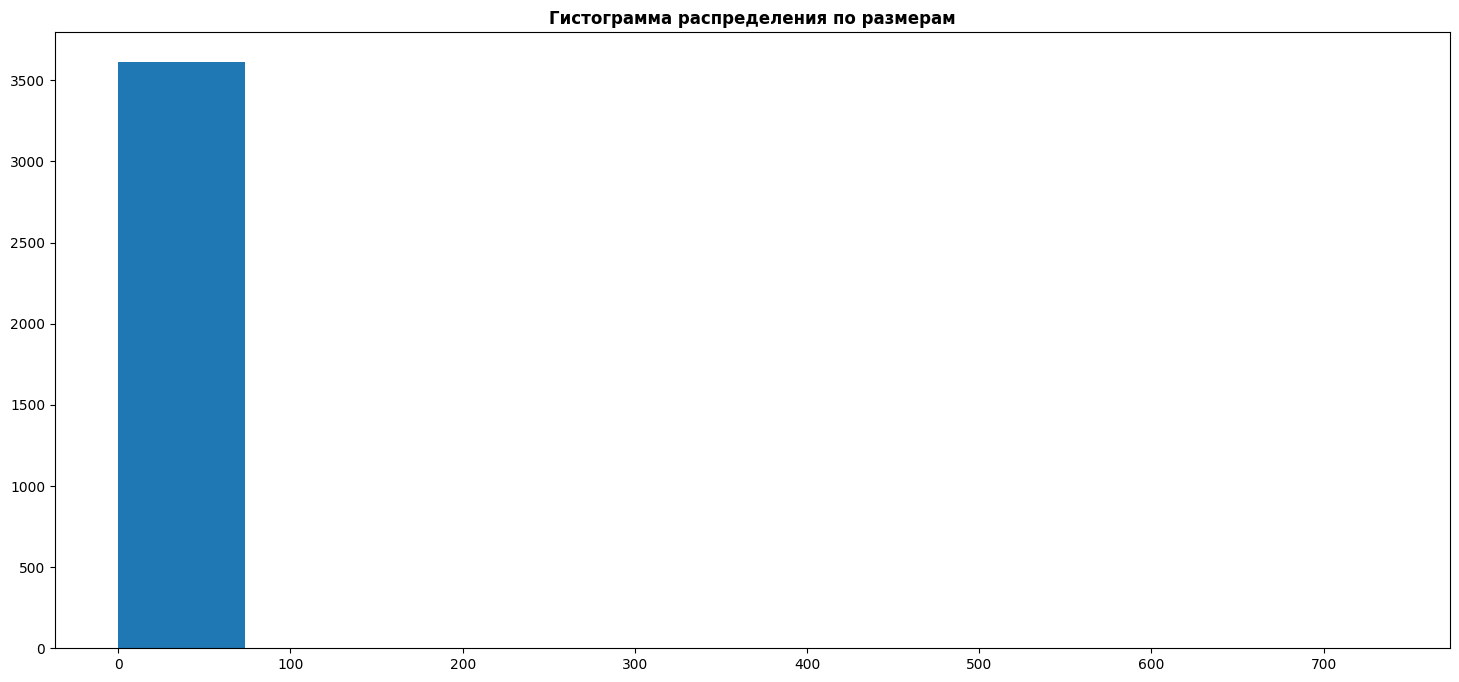

In [6]:
# generateImagesWithFoundObjects(img,
#                                colorToLookFor=COLOR_TO_LOOK_FOR,
#                                tolerance=TOLERANCE,
#                                minArea=MIN_AREA)

getStatistics(img,
              colorToLookFor=COLOR_TO_LOOK_FOR,
              tolerance=TOLERANCE,
              minArea=MIN_AREA)
